# Welcome to GENERALIST tutorial jupyter notebook! 
GENERALIST is a generative model for categorical data. We apply it to protein sequences (21 categories, 20 amino acids + gap), to obtain new sequences. 
We assess the quality of this model through various tests like reproducablity of the statistics of the data and the Hamming distances. 

In this notebook we will use fasta file for P53 present in this repo, you can swap that for any other fasta file. 

We will:
- P53 fasta file ==>`` '../data/msa_p53_unimsa.fa'`` 
- obtain generated sequences 
- run tests on those sequences 

When changing data from string (amino acid letters) to numerical form, we use the correspondance ``AA_Letters = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-' ]`` ==> [0,1,2,....,20]

In [4]:
# import functions
import sys
sys.path.append('../src/')
from compile_generalist_fn import generalist
from data_process_fns import Convert_fastaToNp

To run generalist we need to one hot encode the msa. The function ``Convert_fastaToNp`` takes in a fasta file and gets a 3-D binary matrix of shape ==> [Number of categories (21), Number of sequences, Number of positions in a sequence ]. 



If you are working with another type of categorical you can one hot encode your data to be of the shape ==> [Number of categories , Number of samples , Number of features] and run GENERALIST on that. 

In [5]:
FastaFilePath  = '../data/msa_p53_unimsa.fa' # file path of the fasta file 
# If the MSA file has sequences without labels (no > label line )
# before the sequence, then set labels_inc =False 
data_one_hot = Convert_fastaToNp(filepath = FastaFilePath, binary = True, labels_inc =True)
print(f'Shape of one hot encoded data is {data_one_hot.shape}')

Shape of one hot encoded data is (21, 785, 341)


## Run the inference 

the function ``generalist`` runs the inference and saves parameters $z$ and $\theta$ in the output directory specified in the next cell. The parameters are saved as torch and numpy tensors. 
In the training the model learns the probabilities of having any category/amino acid $a$ in any position $l$ in any specific sample $n$
$$\pi_{anl} = \frac{\exp(- \sum_k z_{nk} \theta_{akl})}{\Omega_{nl}}$$

$K$ is the latent dimension for the model, and is specified by the user. 

``generalist`` uses GPU is available for computation, if not it will use CPU. If GPU is available but you want to run using CPU specify the ``generalist`` argument ``use_gpu_if_avail = False``. 


In [6]:
k= 7 # the latent dimension
output_directory = f'../p53_output_k{k}/' # the output directory where the parameters will be saved 
#This function should detect a gpu if available, otherwise runs on cpu, if GPU is available but you want to run on CPU set use_gpu_if_avail = False 
generalist(sigmas = data_one_hot, k = k, out_dir = output_directory) # 
# parameters are saved in the directory output_directory 

running on cpu
one hot encoded data of size (21, 785, 341)
wrote details file
started inference..
takes 0.09793877601623535 seconds for the first step
Inference is over
step takes 0.09830689430236816 seconds 
Saved files for k = 7
wrote details file
Updated details files
inference done in 0.0016384482383728026 minutes for k = 7
output files at directory ../p53_output_k7/


## Generate data 

Now that the model is trained, we can use the learned probabilies to generate new sequences/samples. The ``Generator`` class uses the output directory where the parameters $z$ and $\theta$ and the latent dimension K defined before to load the files. 

The method ``GenData`` uses those parameters loaded in ``Generator`` object to sample from the probabilities. This method generates sequences in Numerical form [0..20] by default,  or one-hot-encoded if the method argument ``output_binary = True``. 

``GenData`` samples with replacement from the inferred $z$ values, saved in the output directory, and uses the sampled $z$s along with $\theta$ to get sequence probabilities $/pi$ and  generate new sequences, if sampled $z$, $\theta$ or $pi$ are needed then set the argument ``output_params=True``

In [11]:
from loader_class import Generator
import numpy as np 
# ngen = 1000 #number of sequences generated
_, nS , L = data_one_hot.shape
ngen = nS # generate as many sequences as in the natural MSA
Gen_obj = Generator(output_directory, k = k) # define the object 
generated_data = Gen_obj.GenData(ngen) #, output_binary = False
print(generated_data.shape)
# if the parameters Z and Theta are wanted 
# generated_data, z, theta, pi = Gen_obj.GenData(ngen,output_params=True)

(785, 341)


In [8]:
### save the generated dataset as numpy matrix 
file_name = f'generated_data.npy'
output_fn = f'{output_directory}{file_name}'
np.save(output_fn, generated_data)

In [10]:
# if you want to save the generated data as fasta file -- the output of this function is the last saved sequence 
from data_process_fns import Conv_save_NpToFasta
Conv_save_NpToFasta(generated_data, path= output_directory + f'generated_set_k{k}.fa',  label = 'generated_seq', verbose = True , save = True, include_fish_sym = True)


done with save = True


'---MSQSTQTSEFLSPEVFQHIWDFLEQSMDCIRMQDSELSDPQYTNLGLLNSMDQQIQNGSSSTSPYNTDHAQNSVTAPSPYAQPSSTALSPSPAIPSNTDYPGPHSFDVSFQQSSTAKSATWTYSTELKKLYCQIAKTCPIQIKVMTPPPQGAVIRAMPVYKKAEHVTEVVKRCPNHELSRENEGIAPPSHLIRVEGNSHAQYVEDPITGRQSVLVPYEPPQVGTEFTTILYNFMCNSSCVGGMNRRPILIIVTLETRDGQVLGRRCFEARICACPGRDRKADEDSIRKQQVSDST-KNDDAFRQNTHGIQMTSIKKRRSPDEELLYLPVRGRETY---\n'

## Analysis

Now that we have some generated sequences, we can run various tests on them to see how well they match the original ones. 

### The statistics
Calculating single site frequencies the mean removed correlation of various orders. 
The funciton ``Calc_nBody_Corr`` takes the original dataset and the generated dataset as arguments, as well as the order of the statistics, and obtains arrays for the frequencies of amino acid combinations in both datasets. For order > 1, 7000 amino acid combinaitons are randomly sampled.


In [14]:
from performance_fns import Calc_nBody_Corr, calculate_r_metric
import matplotlib.pyplot as plt

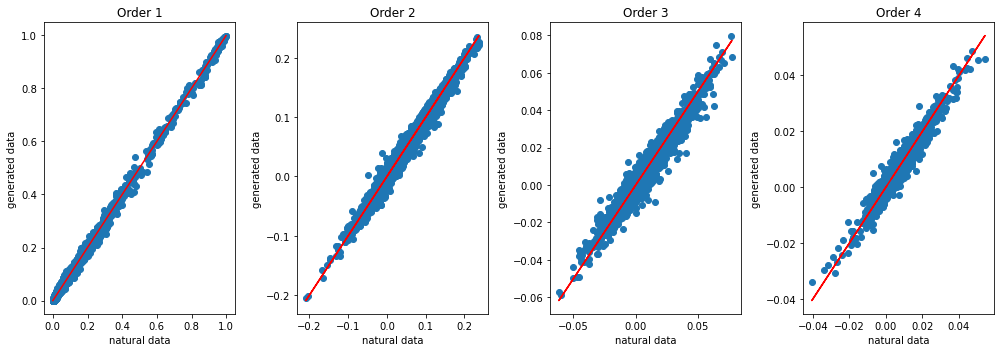

In [27]:
# correlation
order_list = [1,2,3,4]
fig, ax = plt.subplots(ncols = len(order_list), figsize = (14,5))
i = 0
for order in order_list: 
    freq_og, freq_gen =  Calc_nBody_Corr(data_one_hot, generated_data, n = order, mean_removed = True)
    ax[i].scatter(freq_og, freq_gen)
    ax[i].plot(freq_og, freq_og, c = 'r')
    ax[i].set_title(f'Order {order}')
    ax[i].set_xlabel(f'natural data')
    ax[i].set_ylabel(f'generated data')
    i+=1 
plt.tight_layout()

### $r_m$

### Hamming distance